# Data interpolation

Data interpolation is achieved by using the [xesmf](https://xesmf.readthedocs.io/en/latest/) library.

It works easily with `xarray` and `dask` and therefore can manage parallel computation. As a start, let's try to interpolate our global `SST` temperature from the ORCA grid to a regular one.

## Reading of the SST

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe

data = xr.open_dataset("data/surface_thetao.nc")
data = data['thetao']
data

<xarray.DataArray 'thetao' (time_counter: 732, olevel: 1, y: 332, x: 362)>
[87974688 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * olevel         (olevel) float32 0.5058
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1958-01-16 12:00:00 ... 2018-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           sea_water_potential_temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_methods:        time: mean
    cell_measures:       area: area

## Initialisation of the output grid

Then, a `Dataset` object that contains the output grid must be created

In [2]:
dsout = xr.Dataset()
dsout['lon'] = (['lon'], np.arange(-179, 179 + 1))
dsout['lat'] = (['lat'], np.arange(-89, 89 + 1))
dsout

<xarray.Dataset>
Dimensions:  (lon: 359, lat: 179)
Coordinates:
  * lon      (lon) int64 -179 -178 -177 -176 -175 -174 ... 175 176 177 178 179
  * lat      (lat) int64 -89 -88 -87 -86 -85 -84 -83 ... 83 84 85 86 87 88 89
Data variables:
    *empty*

## Renaming the input coordinates

We also need to insure that the coordinates variables have the same names.

In [3]:
data = data.rename({'nav_lon' : 'lon', 'nav_lat' : 'lat'})
data

<xarray.DataArray 'thetao' (time_counter: 732, olevel: 1, y: 332, x: 362)>
[87974688 values with dtype=float32]
Coordinates:
    lat            (y, x) float32 ...
    lon            (y, x) float32 ...
  * olevel         (olevel) float32 0.5058
    time_centered  (time_counter) object 1958-01-16 12:00:00 ... 2018-12-16 1...
  * time_counter   (time_counter) object 1958-01-16 12:00:00 ... 2018-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           sea_water_potential_temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_methods:        time: mean
    cell_measures:       area: area

## Creating the interpolator

When this is done, the interpolator object can be created as follows:

In [4]:
regridder = xe.Regridder(data, dsout, 'bilinear', ignore_degenerate=True, reuse_weights=False, periodic=True, filename='weights.nc')
regridder

/home/barrier/Softwares/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            weights.nc 
Reuse pre-computed weights? False 
Input grid shape:           (332, 362) 
Output grid shape:          (179, 359) 
Periodic in longitude?      True

Note that the `ignore_degenerate` argument is necessary for handling the ORCA grid.

## Interpolating the data set

In [5]:
dataout = regridder(data)

/home/barrier/Softwares/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


## Comparing the results

Let's display the original SST values for the first time-step

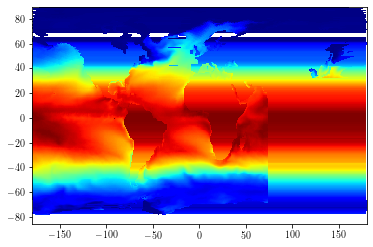

In [6]:
import matplotlib.pyplot as plt

mesh = xr.open_dataset("data/mesh_mask_eORCA1_v2.2.nc")
lonf = mesh['glamf'].data[0]
latf = mesh['gphif'].data[0]

toplot = data.isel(time_counter=0, olevel=0).data
cs = plt.pcolormesh(lonf, latf, toplot[1:, 1:], cmap=plt.cm.jet)
cs.set_clim(-2, 30)

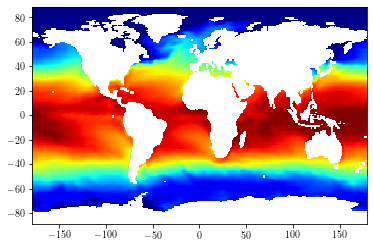

In [7]:
toplot = dataout.isel(time_counter=0, olevel=0).data
cs = plt.pcolormesh(dataout['lon'], dataout['lat'], toplot[1:, 1:], cmap=plt.cm.jet)
cs.set_clim(-2, 30)